## Data Loading

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from  tensorflow.keras.datasets import mnist

(X_train, y_train) , (X_test, y_test) = mnist.load_data()

print(f"X_train shape: {X_train.shape}, y_train shape: { y_train.shape}")
print(f"X_test shape: {X_test.shape} y_test_shape: {y_test.shape}")

11501568/11490434 [==============================] - 0s 0us/step
X_train shape: (60000, 28, 28), y_train shape: (60000,)
X_test shape: (10000, 28, 28) y_test_shape: (10000,)


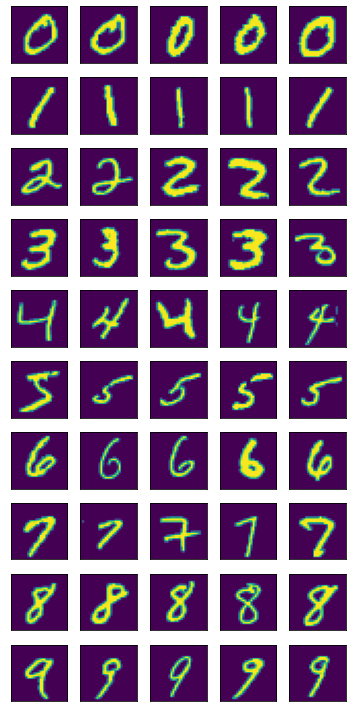

In [ ]:
fig, ax = plt.subplots(10, 5, figsize=(5, 10))

for i in range(10):
    imgs = X_train[y_train == i][:5]
    for j in range(5):
        ax[i, j].imshow(imgs[j])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

fig.tight_layout()


In [ ]:
## To reduce training time, we take a 10% random sample from training and testing data

np.random.seed(4)

train_idxs = np.random.choice(np.arange(X_train.shape[0]), X_train.shape[0]//10)
test_idxs = np.random.choice(np.arange(X_test.shape[0]), X_test.shape[0]//10)

X_train_sample, y_train_sample = X_train[train_idxs], y_train[train_idxs]
X_test_sample, y_test_sample = X_test[test_idxs], y_test[test_idxs]


X_train_sample = X_train_sample.reshape(-1, 784).astype('float32') / 255.0
X_test_sample = X_test_sample.reshape(-1, 784).astype('float32') / 255.0

print(f"X_train shape: {X_train_sample.shape}, y_train shape: { y_train_sample.shape}")
print(f"X_test shape: {X_test_sample.shape} y_test_shape: {y_test_sample.shape}")

X_train shape: (6000, 784), y_train shape: (6000,)
X_test shape: (1000, 784) y_test_shape: (1000,)


In [ ]:
# To make sure our random sample includes all labels,
# we print frequencies in training and testing data

(vals, counts) = np.unique(y_train_sample, return_counts=True)
freqs = np.asarray((vals, counts)).T

print(freqs)

[[  0 601]
 [  1 633]
 [  2 572]
 [  3 620]
 [  4 597]
 [  5 572]
 [  6 598]
 [  7 610]
 [  8 608]
 [  9 589]]


In [ ]:
(vals, counts) = np.unique(y_test_sample, return_counts=True)
freqs = np.asarray((vals, counts)).T

print(freqs)

[[  0 119]
 [  1 111]
 [  2  99]
 [  3  91]
 [  4  91]
 [  5  95]
 [  6  92]
 [  7 121]
 [  8  86]
 [  9  95]]


## k-NN Classifier 

In [ ]:
import numpy as np
from collections import Counter

class KNN():
    def __init__(self, k):
        self.k = k
        self.data = None
        self.labels = None

    def fit(self, data, labels):
        self.data = data
        self.labels = labels

    def compute_distance(self, x1, x2):
        euclidean_distance = np.sqrt(np.sum(np.square((x1 - x2)), axis=1))
        return euclidean_distance

    def predict(self, X_test):
        if(self.data is None):
            print("KNN is not fit")
            return None
        preds = np.zeros(X_test.shape[0])

    for i, test_example in enumerate(X_test):
        dist = self.compute_distance(test_example, self.data)  
        # get the labels of k training examples with minimum distance
        min_idxs = np.argsort(dist)[:self.k]
        neighbor_labels = [self.labels[i] for i in min_idxs]
        # get most occurring label in the acquired list
        preds[i] = np.argmax(np.bincount(neighbor_labels))
      
    return preds

Try KNN with different K's and compute the accuracy

In [ ]:
from sklearn.metrics import accuracy_score

accs = {}

for k in range(1, 11):
    knn = KNN(k)
    knn.fit(X_train_sample, y_train_sample)
    preds = knn.predict(X_test_sample)
    acc = accuracy_score(y_test_sample, preds)
    print(f"Accuracy with k={k} : {acc}")
    accs[k] = acc

Accuracy with k=1 : 0.935
Accuracy with k=2 : 0.92
Accuracy with k=3 : 0.943
Accuracy with k=4 : 0.933
Accuracy with k=5 : 0.943
Accuracy with k=6 : 0.939
Accuracy with k=7 : 0.944
Accuracy with k=8 : 0.945
Accuracy with k=9 : 0.939
Accuracy with k=10 : 0.939


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

knn = KNN(8)
knn.fit(X_train_sample, y_train_sample)
knn_preds = knn.predict(X_test_sample)

KNN Accuracy : 0.945


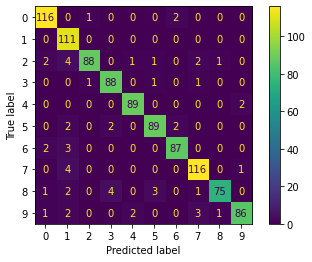

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

knn_acc = accuracy_score(y_test_sample, knn_preds)
knn_conf = confusion_matrix(y_test_sample, knn_preds)
knn_conf_disp = ConfusionMatrixDisplay(confusion_matrix=knn_conf,
                                    display_labels=np.arange(10)) 
print(f"KNN Accuracy : {knn_acc}")
knn_conf_disp.plot()
plt.show()


# KNN Discussion

In order to determine the best k, we try different numbers ranging from 1 to 10. While the results are very similar, k=8 achieves the best results with accuracy of 93.5%. By plotting the confusion matrix, we can see that all 1's were classified correctly, and 4 7's were incorrectly classified as 1, probably because with different handwritings 7 can look very similar to 1. Similarly, 4 8's were misclassified as 3, because of the similarity in the curves of the 2 numbers.

## Logistic Regression One-vs-Rest


In [ ]:
from sklearn.linear_model import LogisticRegression

def fit_OVR(X, y):
    models = []
    for i in range(10):
        y_train = y.copy()
        y_train[y == i] = 1
        y_train[y != i] = 0
        lr = LogisticRegression(max_iter=500)
        lr.fit(X, y_train)
        models.append(lr)
return models

def predict_OVR(models, X_test):
    probs = np.zeros(shape=(10, X_test.shape[0]))
    for i, model in enumerate(models):
        probs[i] = model.predict_proba(X_test)[:, 1]
    preds = np.argmax(probs, axis=0)
    return preds

In [ ]:
models = fit_OVR(X_train_sample, y_train_sample)
ovr_preds = predict_OVR(models, X_test_sample)

OVR Accuracy : 0.891


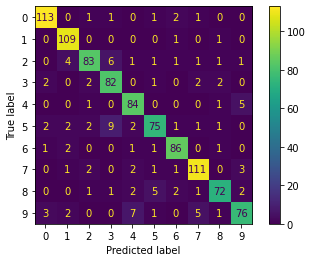

In [ ]:
ovr_acc = accuracy_score(y_test_sample, ovr_preds)
ovr_conf = confusion_matrix(y_test_sample, ovr_preds)

ovr_conf_disp = ConfusionMatrixDisplay(confusion_matrix=ovr_conf,
                                    display_labels=np.arange(10)) 
print(f"OVR Accuracy : {ovr_acc}")
ovr_conf_disp.plot()
plt.show()

## SVM


In [ ]:
def visualize_accs(accs, xlabel):
    vals, accs =  zip(*sorted(accs.items()))
    plt.plot(vals, accs)
    plt.xlabel(xlabel)
    plt.xscale("log")
    plt.ylabel("Accuracy")

### Linear SVC

In [ ]:
from sklearn.svm import LinearSVC

baseline_svc = LinearSVC(dual=False)
baseline_svc.fit(X_train_sample, y_train_sample)
baseline_preds = baseline_svc.predict(X_test_sample)

print("Baseline training acc = {:.2f}".format(baseline_svc.score(X_train_sample, y_train_sample)))
print("Baseline testomg acc = {:.2f}".format(baseline_svc.score(X_test_sample, y_test_sample)))

Baseline training acc = 0.98
Baseline testomg acc = 0.88


### Tune C parameter

In [ ]:
c_vals =  [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]
c_accs = {}

for c in c_vals:
    linear_svc = LinearSVC(C=c, dual=False)
    linear_svc.fit(X_train_sample, y_train_sample)
    c_accs[c] = linear_svc.score(X_test_sample, y_test_sample)
    train_acc = linear_svc.score(X_train_sample, y_train_sample)
    print("Training acc = {:.2f} testing acc = {:.2f} with C={}".format(train_acc, c_accs[c], c))

Training acc = 0.85 testing acc = 0.84 with C=0.0001
Training acc = 0.90 testing acc = 0.89 with C=0.001
Training acc = 0.93 testing acc = 0.90 with C=0.01
Training acc = 0.96 testing acc = 0.89 with C=0.1
Training acc = 0.98 testing acc = 0.88 with C=1
Training acc = 0.99 testing acc = 0.85 with C=10


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training acc = 1.00 testing acc = 0.83 with C=100
Training acc = 1.00 testing acc = 0.82 with C=1000


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


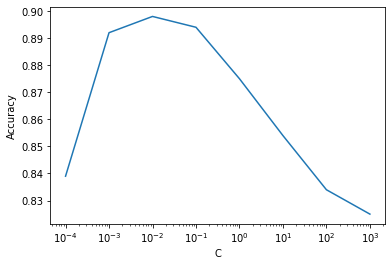

In [ ]:
visualize_accs(c_accs, "C")

### Add Regularization

In [ ]:
c_vals =  [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]
c_accs = {}

for c in c_vals:
    linear_svc = LinearSVC(C=c, dual=False, penalty='l1')
    linear_svc.fit(X_train_sample, y_train_sample)
    c_accs[c] = linear_svc.score(X_test_sample, y_test_sample)
    train_acc = linear_svc.score(X_train_sample, y_train_sample)
    print("Training acc = {:.2f} testing acc = {:.2f} with C={}".format(train_acc, c_accs[c], c))

Training acc = 0.10 testing acc = 0.12 with C=0.0001
Training acc = 0.46 testing acc = 0.49 with C=0.001
Training acc = 0.87 testing acc = 0.85 with C=0.01
Training acc = 0.93 testing acc = 0.90 with C=0.1


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training acc = 0.98 testing acc = 0.89 with C=1


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training acc = 1.00 testing acc = 0.85 with C=10


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training acc = 1.00 testing acc = 0.84 with C=100
Training acc = 1.00 testing acc = 0.84 with C=1000


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


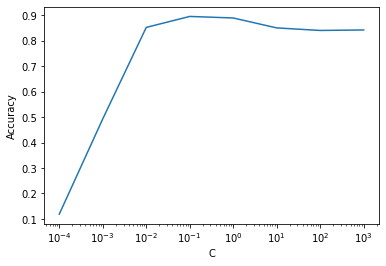

In [ ]:
visualize_accs(c_accs, "C")

### SVM with RBF Kernel

In [ ]:
from sklearn.svm import SVC

accs = {}

for c in [0.01, 0.1, 1, 10, 100]:
    c_accs = []
    for gamma in [0.01, 0.1, 1, 10, 100]:
        svc = SVC(C=c, kernel='rbf', gamma=gamma, random_state=4)
        svc.fit(X_train_sample, y_train_sample)
        acc = svc.score(X_test_sample, y_test_sample)
        c_accs.append(acc)
        train_acc = svc.score(X_train_sample, y_train_sample)
        print("Training acc = {:.2f} testing acc = {:.2f} with C={} and gamma={}".format(train_acc, acc, c, gamma))
    accs[c] = c_accs

Training acc = 0.65 testing acc = 0.63 with C=0.01 and gamma=0.01
Training acc = 0.11 testing acc = 0.11 with C=0.01 and gamma=0.1
Training acc = 0.11 testing acc = 0.11 with C=0.01 and gamma=1
Training acc = 0.11 testing acc = 0.11 with C=0.01 and gamma=10
Training acc = 0.11 testing acc = 0.11 with C=0.01 and gamma=100
Training acc = 0.92 testing acc = 0.93 with C=0.1 and gamma=0.01
Training acc = 0.22 testing acc = 0.20 with C=0.1 and gamma=0.1
Training acc = 0.11 testing acc = 0.11 with C=0.1 and gamma=1
Training acc = 0.11 testing acc = 0.11 with C=0.1 and gamma=10
Training acc = 0.11 testing acc = 0.11 with C=0.1 and gamma=100
Training acc = 0.98 testing acc = 0.95 with C=1 and gamma=0.01
Training acc = 1.00 testing acc = 0.86 with C=1 and gamma=0.1
Training acc = 1.00 testing acc = 0.15 with C=1 and gamma=1
Training acc = 1.00 testing acc = 0.11 with C=1 and gamma=10
Training acc = 1.00 testing acc = 0.11 with C=1 and gamma=100
Training acc = 1.00 testing acc = 0.96 with C=10 an

In [ ]:
svc = SVC(C=10, kernel='rbf', gamma=0.01, random_state=4)
svc.fit(X_train_sample, y_train_sample)

train_acc = svc.score(X_train_sample, y_train_sample)
test_acc = svc.score(X_test_sample, y_test_sample)
print("Training acc = {:.2f} testing acc = {:.2f}".format(train_acc, test_acc))

Training acc = 1.00 testing acc = 0.96


SVC Accuracy : 0.963


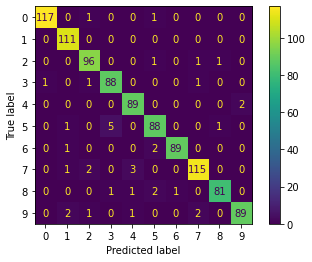

In [ ]:
svc_preds = svc.predict(X_test_sample)
svc_acc = accuracy_score(y_test_sample, svc_preds)
svc_conf = confusion_matrix(y_test_sample, svc_preds)
svc_conf_disp = ConfusionMatrixDisplay(confusion_matrix=svc_conf,
                                    display_labels=np.arange(10)) 
print(f"SVC Accuracy : {svc_acc}")
svc_conf_disp.plot()
plt.show()

# SVM Discussion


The baseline LinearSVC achieves an accuracy of 0.88 on testing data, and the default C is 1.0. With the same linear kernel but with a smaller C of 0.1, we achieve an slightly higher accuracy of 0.90. With the smaller C, the margin is larger and therefore is less sensitive to outliers so this improves the overall performance. 

We can see that with larger values of C like 1, 10, 100, we achieve a training accuracy of almost 1, but with a lower testing accuracy of around 0.84. This indicates that we may be overfitting the data, since the margin is getting smaller to correctly classify all the training data even those that may be considered outliers, so we end up misclassifiying more samples from the test data.

Adding L1 regularization did not improve the performance, since LinearSVC by default uses L2 regularization, and there is no option to remove regularization.

Changing the kernel to RBF and varying gamma and c together improved our testing performance. This indicates that the problem may not be linearly separable, and using a nonlinear kernel improves the accuracy. It may be worthy to explore other kernels as well, and use the one that best suits the problem. 

By looking at the confusion matrix, there is no pattern in the off-diagonal terms and no significant numbers, however in the true label 8, we can see many misclassified examples, probably because parts of the number 8 are similar to other numbers like 3 and 6, which makes it harder to capture the differences using only raw pixels.


# Feature extraction instead of raw pixels.

In [ ]:
import skimage

In [ ]:
from skimage.feature import hog

def extract_hog(X_test, orientations=9):
    hog_features = []
    
    for test_sample in X_test:
        fd = hog(test_sample.reshape((28,28)), orientations=orientations, feature_vector=True)
        hog_features.append(fd)

    return hog_features

X_train_hog = extract_hog(X_train_sample)
X_test_hog = extract_hog(X_test_sample)

In [ ]:
from sklearn.svm import SVC

accs = {}

for c in [0.01, 0.1, 1, 10, 100]:
    c_accs = []
    for gamma in [0.01, 0.1, 1, 10, 100]:
        svc = SVC(C=c, kernel='rbf', gamma=gamma, random_state=4)
        svc.fit(X_train_hog, y_train_sample)
        acc = svc.score(X_test_hog, y_test_sample)
        c_accs.append(acc)
        train_acc = svc.score(X_train_hog, y_train_sample)
        print("Training acc = {:.2f} testing acc = {:.2f} with C={} and gamma={}".format(train_acc, acc, c, gamma))
    accs[c] = c_accs

Training acc = 0.11 testing acc = 0.11 with C=0.01 and gamma=0.01
Training acc = 0.12 testing acc = 0.12 with C=0.01 and gamma=0.1
Training acc = 0.77 testing acc = 0.76 with C=0.01 and gamma=1
Training acc = 0.11 testing acc = 0.11 with C=0.01 and gamma=10
Training acc = 0.11 testing acc = 0.11 with C=0.01 and gamma=100
Training acc = 0.15 testing acc = 0.16 with C=0.1 and gamma=0.01
Training acc = 0.88 testing acc = 0.89 with C=0.1 and gamma=0.1
Training acc = 0.94 testing acc = 0.93 with C=0.1 and gamma=1
Training acc = 0.78 testing acc = 0.68 with C=0.1 and gamma=10
Training acc = 0.11 testing acc = 0.11 with C=0.1 and gamma=100
Training acc = 0.88 testing acc = 0.89 with C=1 and gamma=0.01
Training acc = 0.94 testing acc = 0.93 with C=1 and gamma=0.1
Training acc = 0.98 testing acc = 0.96 with C=1 and gamma=1
Training acc = 1.00 testing acc = 0.93 with C=1 and gamma=10
Training acc = 1.00 testing acc = 0.11 with C=1 and gamma=100
Training acc = 0.94 testing acc = 0.93 with C=10 an

##  Conclusion


# KNN
KNN is a simple algorithm that requires no training but requires longer time to make predictions because it scans the whole training data (at least with the current simple implementation). It was able to achieve accuracy of 94.3%, however on the full dataset it takes a very long time to generate predictions, therefore it is not suitable for generating a large number of predictions. It also requires that all training data be available at test time, which consumes a lot of memory in addition to time. 

# One-vs-Rest Logistic Regression
With this approach, we train a binary classifier for each of our classes. To make predictions, we use each of the trained classifier and choose the one with maximum probability. It generates predictions quickly, but achieves the lowest accuracy of all classifiers, only 89%, which makes more suitable for the task if computational complexity is an issue. It could however possibly perform better on more carefully crafted features rather than raw pixels, because it is significantly harder to capture information from raw pixels, and they are highly correlated.

# SVM
Kernel SVM outperforms all other classifiers, because of its ability to capture nonlinear relationships. Therefore, it is the most appropriate one to use for this task. While it requires longer time to train, it is able to provide predictions quickly, much faster than the knn, and does not require all the training data to be available at test time, making it much cheaper to deploy. 

# HOG Features
The images in MNIST dataset are of shape 28*28, and if we flatten them we get an input vector of shape 784. This big vector makes training SVMs for example a time consuming process, also because it's more difficult to extract  patterns from raw pixels. As a different approach, we extract different features from the images, to make the learning task easier. For example, I extracted histogram of oriented gradients from the raw images, and using the default parameters of 9 orientations, we get a feature vector that is only 81 entries long. This makes training SVMs significantly faster, and yields very similar accuracy to using the raw pixels. We can further improve the accuracy by tweaking the parameters a little bit.  